In [17]:
import pandas as pd
import numpy as np

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')


In [18]:
customer_transactions = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

In [19]:
customer_features = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum', 
    'TransactionID': 'count',  
    'Quantity': 'sum', 
}).reset_index()

customer_features = pd.merge(customer_features, customers_df, on='CustomerID', how='left')

In [20]:
print("Prepared Customer Features:")
display(customer_features.head())

Prepared Customer Features:


,CustomerID,TotalValue,TransactionID,Quantity,CustomerName,Region,SignupDate
0,C0001,3354.52,5,12,Lawrence Carroll,South America,2022-07-10
1,C0002,1862.74,4,10,Elizabeth Lutz,Asia,2022-02-13
2,C0003,2725.38,4,14,Michael Rivera,South America,2024-03-07
3,C0004,5354.88,8,23,Kathleen Rodriguez,South America,2022-10-09
4,C0005,2034.24,3,7,Laura Weber,Asia,2022-08-15


In [22]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

encoder = OneHotEncoder(sparse_output=False)  
region_encoded = encoder.fit_transform(customer_features[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))


clustering_data = pd.concat([
    customer_features[['TotalValue', 'TransactionID', 'Quantity']], 
    region_encoded_df  
], axis=1)


scaler = MinMaxScaler()
clustering_data_normalized = scaler.fit_transform(clustering_data)

print("Normalized Features for Clustering:")
print(pd.DataFrame(clustering_data_normalized, columns=clustering_data.columns).head())


Normalized Features for Clustering:
   TotalValue  TransactionID  Quantity  Region_Asia  Region_Europe  \
0    0.308942            0.4  0.354839          0.0            0.0   
1    0.168095            0.3  0.290323          1.0            0.0   
2    0.249541            0.3  0.419355          0.0            0.0   
3    0.497806            0.7  0.709677          0.0            0.0   
4    0.184287            0.2  0.193548          1.0            0.0   

   Region_North America  Region_South America  
0                   0.0                   1.0  
1                   0.0                   0.0  
2                   0.0                   1.0  
3                   0.0                   1.0  
4                   0.0                   0.0  


In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score


k = 4 
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(clustering_data_normalized)
customer_features['Cluster'] = clusters


db_index = davies_bouldin_score(clustering_data_normalized, clusters)
silhouette_avg = silhouette_score(clustering_data_normalized, clusters)

print(f"Number of Clusters: {k}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


Number of Clusters: 4
Davies-Bouldin Index: 0.43125421154304205
Silhouette Score: 0.726503044019441


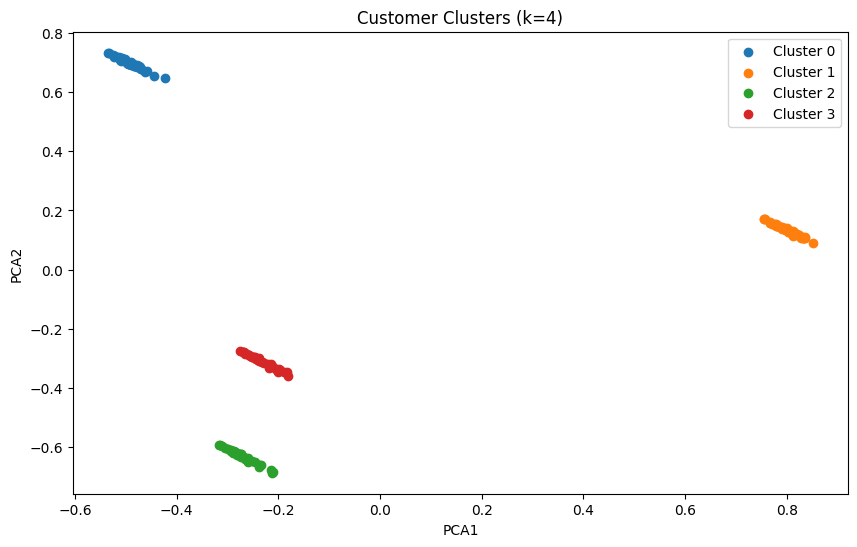

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(clustering_data_normalized)


customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]


plt.figure(figsize=(10, 6))
for cluster in range(k):
    cluster_data = customer_features[customer_features['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title(f'Customer Clusters (k={k})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


In [27]:
customer_features.to_csv('Customer_Segmentation.csv', index=False)

print("Clustering results saved to 'Customer_Segmentation.csv'.")


print("Sample Clustering Results:")
display(customer_features[['CustomerID', 'Cluster', 'TotalValue', 'TransactionID', 'Quantity']].head())



Clustering results saved to 'Customer_Segmentation.csv'.
Sample Clustering Results:


,CustomerID,Cluster,TotalValue,TransactionID,Quantity
0,C0001,1,3354.52,5,12
1,C0002,3,1862.74,4,10
2,C0003,1,2725.38,4,14
3,C0004,1,5354.88,8,23
4,C0005,3,2034.24,3,7


In [28]:
numeric_columns = customer_features.select_dtypes(include=['number'])
numeric_columns['Cluster'] = customer_features['Cluster']
cluster_means = numeric_columns.groupby('Cluster').mean()

print(cluster_means)



          TotalValue  TransactionID   Quantity      PCA1      PCA2
Cluster                                                           
0        3325.092600       4.680000  11.900000 -0.493521  0.699324
1        3717.840000       5.152542  13.372881  0.800675  0.133558
2        3311.160870       5.304348  12.891304 -0.270865 -0.631927
3        3456.249318       4.954545  12.727273 -0.229636 -0.313125


In [11]:
print(customer_features.groupby('Cluster')['Region'].value_counts())


Cluster  Region       
0        Europe           50
1        South America    59
2        North America    46
3        Asia             44
Name: count, dtype: int64


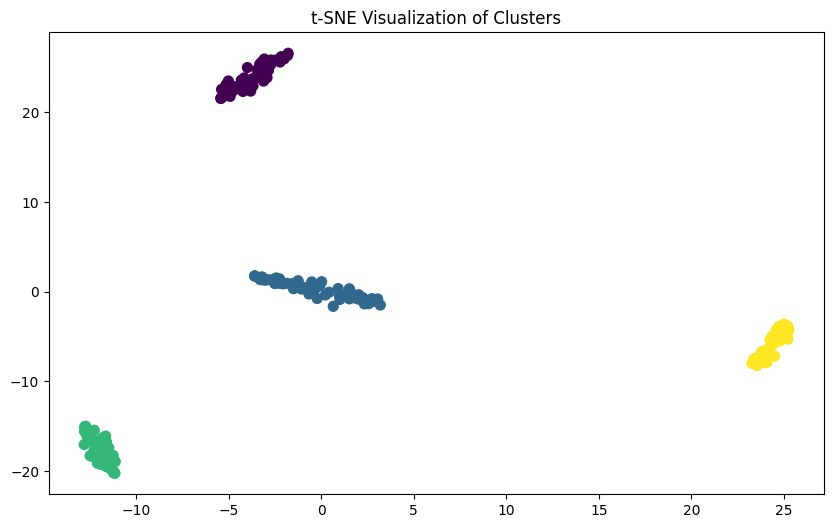

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(clustering_data_normalized)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=customer_features['Cluster'], cmap='viridis', s=50)
plt.title('t-SNE Visualization of Clusters')
plt.show()


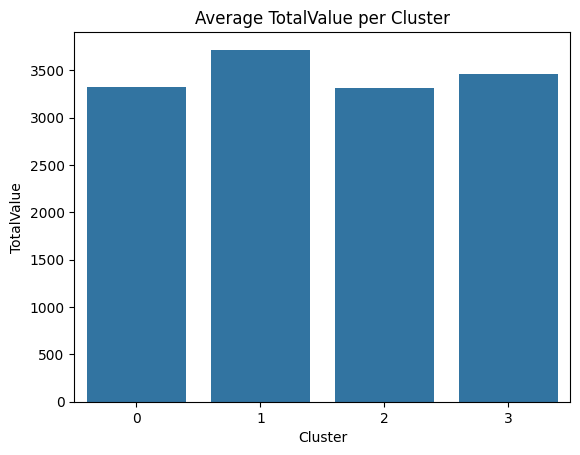

In [14]:
import seaborn as sns
sns.barplot(data=customer_features, x='Cluster', y='TotalValue', errorbar=None)
plt.title('Average TotalValue per Cluster')
plt.show()


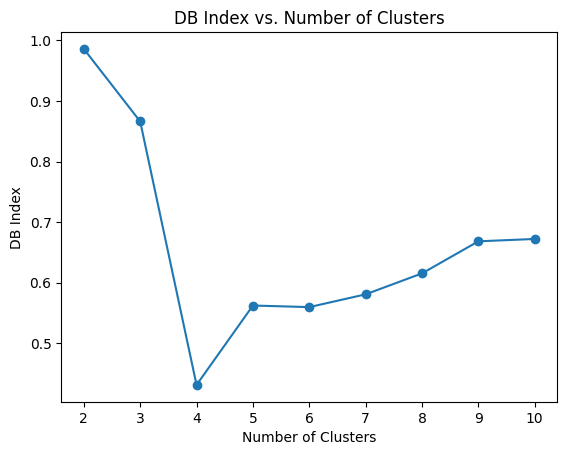

In [15]:
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(clustering_data_normalized)
    clusters = kmeans.labels_
    db_scores.append(davies_bouldin_score(clustering_data_normalized, clusters))

plt.plot(range(2, 11), db_scores, marker='o')
plt.title('DB Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()
